### Tree-based methods

This notebook deals with the tree-based methods used for builiding bitcoin price prediction models. 

The following tree-based methods are used:

1. Decision tree regressor
2. Random forest regressor
3. Gradient boosting regressor

The general way of method validation is shown below (the picture is not displayed on github, the author is working on that)
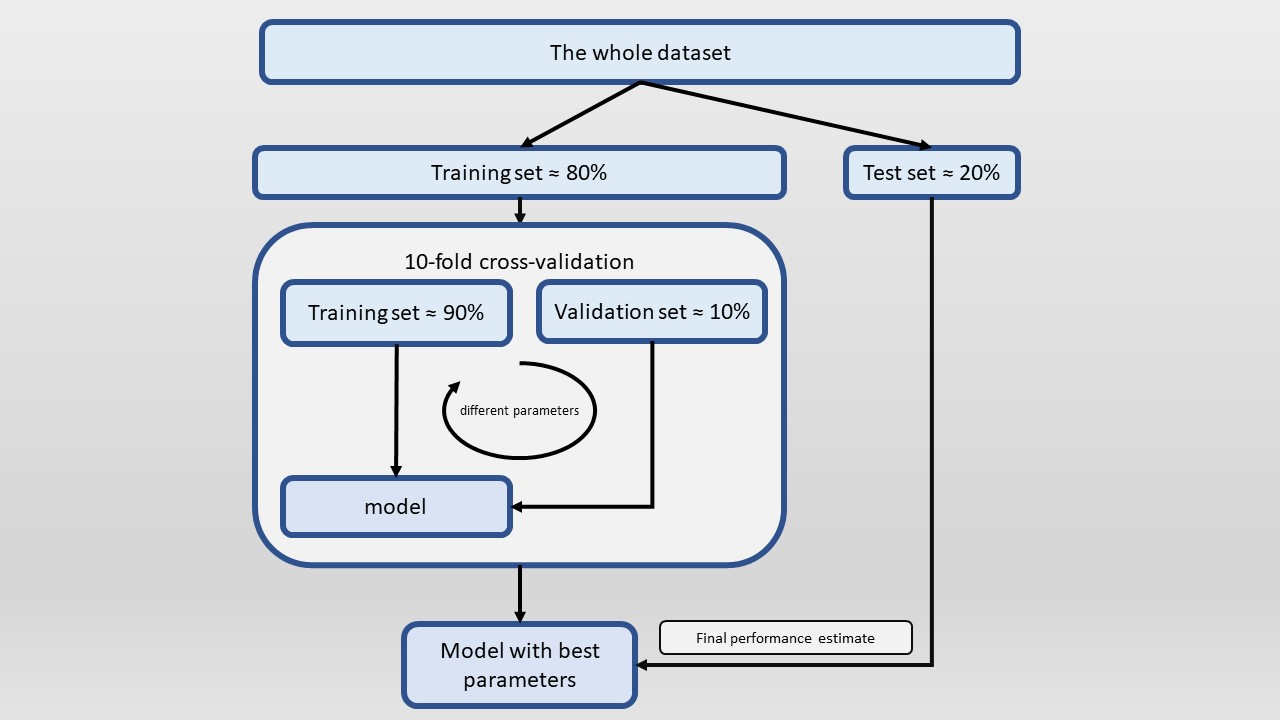

The main dataset is split into two sets: the training set and the test set. The best parameters for each method are selected by the cross-validation method. At the end each method is trained on the whole training set and final evaluation is carried out on the test set. __Note:__  cross-validation is not necessary for random forest. 
Performance of a method is evaluated by calculating the root mean squared error (RMSE). All parameters are searched using the GridSearchCV method. The best method is then evaluated further by investigating nominal and percentage error as well as resiudal plots.

In [114]:
import pandas as pd
import numpy as np
from scipy.stats import probplot
import datetime

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split,cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-whitegrid')
sns.set(font_scale=1.5)

__Loading the dataset__

In [115]:
data=pd.read_csv('data_cleaning/Bitcoin_dataset_updated.csv',index_col='Date')
data.index=pd.to_datetime(data.index,format='%Y-%m-%d')
data.fillna(method='ffill',inplace=True)
data.head()

,BTC price [USD],n-transactions,fee [USD],btc search trends,Gold price[USD],SP500 close index,Oil WTI price[USD],M2(Not seasonally adjusted)[1e+09 USD]
Date,,,,,,,,
2014-01-02,749.27,54770.0,0.18,8,1225.0,1831.98,95.14,11089.3
2014-01-03,781.23,60980.0,0.18,8,1238.4,1831.37,93.66,11089.3
2014-01-04,807.39,52052.0,0.18,8,1238.4,1831.37,93.66,11089.3
2014-01-05,828.74,58662.0,0.38,8,1238.4,1831.37,93.66,11089.3
2014-01-06,904.98,67358.0,0.38,8,1237.8,1826.77,93.12,11089.3


In [116]:
#function that uses GridSearchCV method for searching the best parameters
def search_params(*,model,X,y,parameters,cv=10):
    GScv=GridSearchCV(estimator=model,param_grid=parameters,scoring='neg_root_mean_squared_error',cv=cv)
    GScv.fit(X,y)
    return GScv.best_params_,-GScv.best_score_

In [117]:
#function for the final estimate 
def final_estimate(*,model,X_train,X_test,y_train,y_test,best_pars):
    model_temp=model(**best_pars)
    model_temp.fit(X_train,y_train)
    y_pred=model_temp.predict(X_test)
    return mean_squared_error(y_test,y_pred,squared=False)

Preparing _X_ and _y_ matrices

In [118]:
X=data.drop('BTC price [USD]',axis=1)
y=data['BTC price [USD]']
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.8,shuffle=True)

### Regression tree

Parameters to be optimized: 
- maximum depth of tree
- minimum number of samples required to be at a leaf node

In [119]:
depths=np.arange(1,30,1)
min_leaf_number=np.arange(1,6)

DecisionTreePar=[{'max_depth':depths, 'min_samples_leaf':min_leaf_number}]

DT_best_par,DT_best_score=search_params(model=DecisionTreeRegressor(),X=X_train,y=y_train,parameters=DecisionTreePar)

print('Best score for decision tree: {}, best parameters: {}'.format(DT_best_score,DT_best_par))

Best score for decision tree: 496.16801236514374, best parameters: {'max_depth': 23, 'min_samples_leaf': 4}


### Random Forest Regression

Random forest regression does not need cross-validation, _cv_ number is set to two. Variables to be optimized: 
 - maximum depth of tree 
 - number of features to consider when looking for the best split. 
 - number of trees in the forest

__optimizing this tree takes a while - part of this section appears as a comment, obtained results are assigned by hand__


In [120]:
depths=np.arange(1,20,1)
max_features=np.arange(1,X.shape[1]+1,1)
max_tree=np.arange(200,1000,200)

RandomForestRegPar=[{'max_depth':depths, 'max_features':max_features,'n_estimators':max_tree}]

#to start optimizing random forest regression the line below needs to be uncommented
# RFR_best_par,RFR_best_score=search_params(model=RandomForestRegressor(),X=X_train,y=y_train,parameters=RandomForestRegPar,cv=2)

RFR_best_par={'max_depth': 17, 'max_features': 2, 'n_estimators': 200}
RFR_best_score= 397.2111535637895
print('Best score for RandomForestRegression tree: {}, best parameters: {}'.format(RFR_best_score,RFR_best_par))

Best score for RandomForestRegression tree: 397.2111535637895, best parameters: {'max_depth': 17, 'max_features': 2, 'n_estimators': 200}


### GradientBoostingRegressor
Parameters to be optimized: 
 - learning rate
 - maximum depth of tree
 - number of boosting stages
 
__optimizing this tree takes a while - part of this section appears as a comment, obtained results are assigned by hand__

In [121]:
depths=np.arange(1,15,1)
num_of_trees=np.array([50,100,200,300,500])
learning_rates=np.array([0.001,0.01,0.1,0.2])

GradientBoostingRegPar=[{'n_estimators':num_of_trees,
                       'max_depth':depths,
                       'learning_rate':learning_rates}]
#to start optimizing gradient boosting regressor the line below needs to be uncommented
# GBR_best_par,GBR_best_score=search_params(model=GradientBoostingRegressor(),X=X_train,y=y_train,parameters=GradientBoostingRegPar,cv=10)

GBR_best_par={'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
GBR_best_score= 363.49102361116746

print('Best score for GradientBoostingRegressor tree: {}, best parameters: {}'.format(GBR_best_score,GBR_best_par))


Best score for GradientBoostingRegressor tree: 363.49102361116746, best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}


#### Final evaluation 

In [122]:
import re

models=[DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor]
pars=[DT_best_par,RFR_best_par,GBR_best_par]

for m,p in zip(models,pars):
    name=re.findall("\w+'>",str(m))[0][:-2]
    score=final_estimate(model=m,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,best_pars=p)
    print('RMSE of the test set for {} = {}'.format(name,round(score,2)))


RMSE of the test set for DecisionTreeRegressor = 519.75
RMSE of the test set for RandomForestRegressor = 342.04
RMSE of the test set for GradientBoostingRegressor = 360.77


Comment: First of all the tree methods perfom much better than regression (RMSE for the best model using linear regression was equal to $ \approx 1200 $). RandomForestRegressor obtained the best result and this method will be investigated further.

### Further investigation of RandomForestRegressor

Feature importances

In [123]:
model=RandomForestRegressor(**RFR_best_par)
model.fit(X_train,y_train)
y_pred=model.predict(X_test)

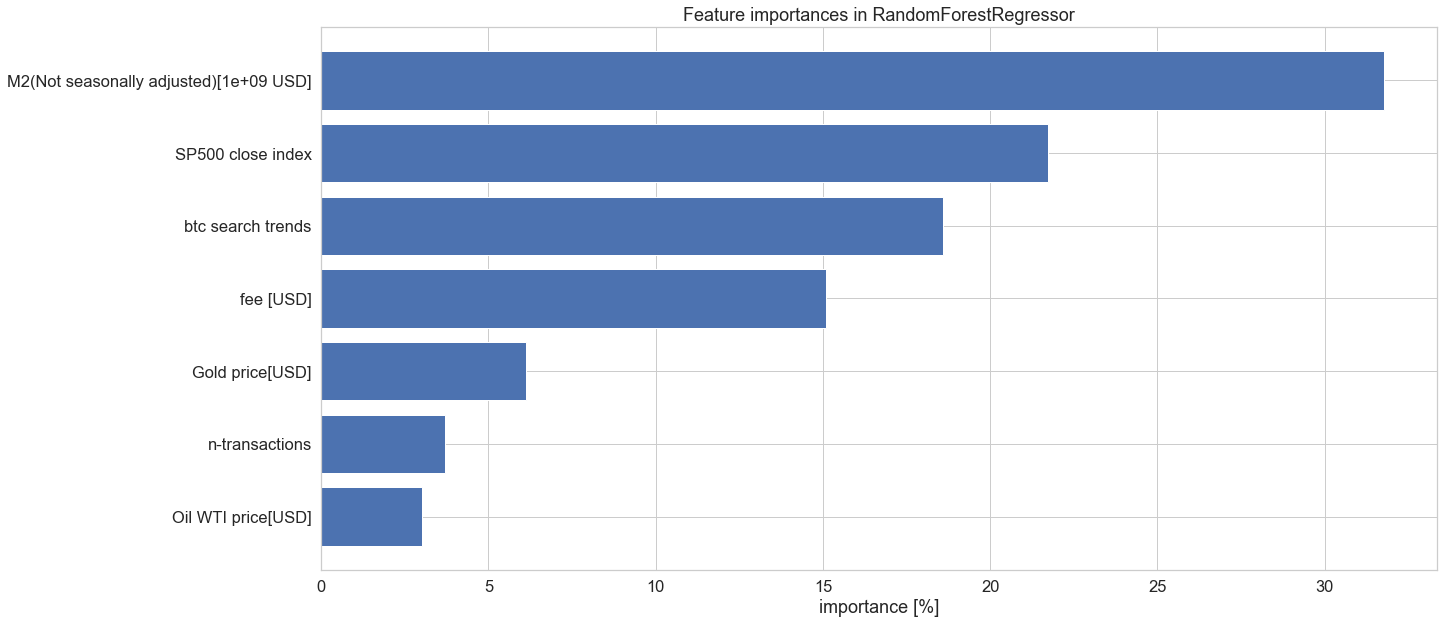

In [124]:
sns.set(style='whitegrid',font_scale=1.5)
idx_sorted=model.feature_importances_.argsort()
plt.figure(figsize=(20,10))
plt.barh(X.columns[idx_sorted],width=model.feature_importances_[idx_sorted]*100)
plt.xlabel('importance [%]')
plt.title('Feature importances in RandomForestRegressor')
plt.show()

Accuracy of predictions

In [125]:
prediction=pd.DataFrame(data=np.hstack( (y_test.values.reshape(-1,1),y_pred.reshape(-1,1))),
             columns=['true price','predicted price'],
            index=y_test.index)
prediction.sort_index(inplace=True)
prediction.head(10)

,true price,predicted price
Date,,
2014-01-05,828.74,917.447500
2014-01-07,915.69,924.078550
2014-01-10,826.28,825.122450
2014-01-15,816.00,809.985750
2014-01-20,841.10,808.191500
2014-01-21,827.81,810.952317
2014-01-26,805.00,792.759978
2014-01-28,747.57,806.162443
2014-01-30,794.00,792.877483


The value of RMSE is not very meaningful because the whole time period was taken into account. For example in 2014 bitcoin price was about 400$. To have better insigh into the method accuracy the percentage error is calculated with the formula

$$ \epsilon_{percentage} = \frac{Price_{true} - Price_{predicted}}{Price_{true}} $$

In [126]:
#function for assigning percentage error interval
def percentage_discrete(x):
    x=abs(x)
    if x>0 and x<=10:
        return 1
    elif x>10 and x<=20:
        return 2
    elif x>20 and x<=30:
        return 3
    elif x>30 and x<=40:
        return 4
    elif x>40 and x<=50:
        return 5
    elif x>50 and x<=60:
        return 6
    elif x>60 and x<=70:
        return 7
    elif x>70 and x<=80:
        return 8
    elif x>80 and x<=90:
        return 9
    else: return 10

In [127]:
prediction['percentage error [%]']=100*(prediction.iloc[:,0]-prediction.iloc[:,1])/prediction.iloc[:,0]
prediction['percentage error discrete']=prediction['percentage error [%]'].apply(percentage_discrete)
prediction.head()

,true price,predicted price,percentage error [%],percentage error discrete
Date,,,,
2014-01-05,828.74,917.44750,-10.703900,2
2014-01-07,915.69,924.07855,-0.916091,1
2014-01-10,826.28,825.12245,0.140092,1
2014-01-15,816.00,809.98575,0.737040,1
2014-01-20,841.10,808.19150,3.912555,1


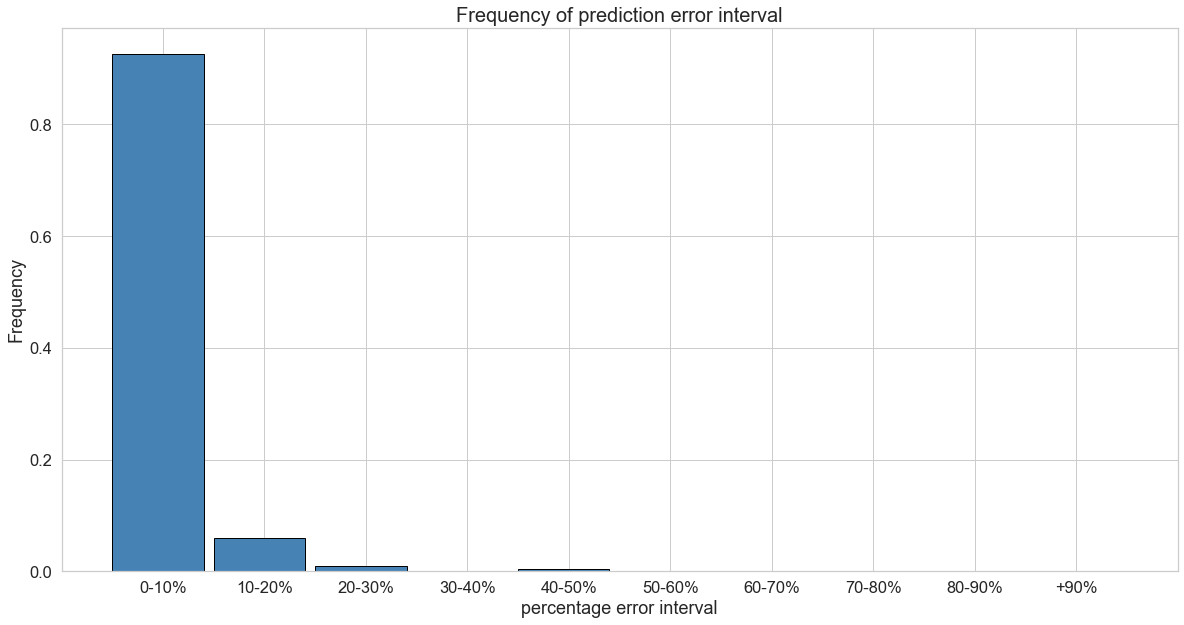

There is no error greater than 50%
the mean percentage error = 3.960833801564044


In [128]:
bins=np.arange(1,12,1)
prediction['percentage error discrete'].plot(kind='hist',
                                             bins=bins,width=0.9,
                                             align='left',
                                             density=True,
                                             figsize=(20,10),
                                             ec='black',
                                             color='steelblue')

labels=[str(i)+'-'+str(j)+'%' for i,j in zip(np.arange(0,90,10),np.arange(10,100,10))]
labels.append('+90%')

plt.xticks(np.arange(1,12,1),labels=labels)
plt.xlabel('percentage error interval')
plt.ylabel('Frequency')
plt.title('Frequency of prediction error interval',fontsize=20)
plt.show()

try:
    greater50=np.unique(np.where(abs(prediction['percentage error [%]'].values)>=50,1,0),return_counts=True)[1][1]
    print('number of errors greater than 50% = {} out of {} predictions'.format(greater50,X_test.shape[0]))
except:
    print("There is no error greater than 50%")


print('the mean percentage error = {}'.format(prediction['percentage error [%]'].abs().mean()))

The model is wrong by $ \approx $ 4% on average! Over 85% of the error lies in the 0-10% interval. It means that 85% of the predictions out of 396 is less than 10%. __Reminder:__ The testset was not involved in selecting the best parameters! <br>

__Charts evaluating the model performance__

1.True vs. predicted price

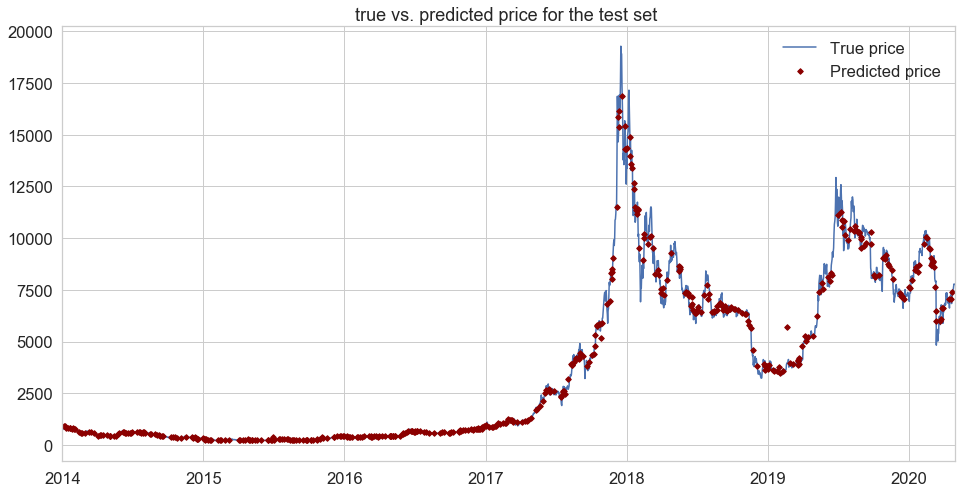

In [129]:
# prediction[['true price','predicted price']].plot(kind='line',color=['r','b'],figsize=(20,10),lw=2)
# plt.ylabel('price [$]')
# plt.show()

datemin = datetime.date(data.index.min().year, data.index.min().day-1, 1)
datemax = datetime.date(data.index.max().year, data.index.max().month + 1, 1)

plt.figure(figsize=(16,8))
plt.plot(data.index,data['BTC price [USD]'],'-',label='True price')
plt.plot(prediction.index,prediction['predicted price'],'D',markersize=4,color='darkred',label='Predicted price')
plt.grid(b=True)
plt.title('true vs. predicted price for the test set ')
plt.xlim([datemin,datemax])
plt.legend()
plt.show()

2. Percentage and nominal errors

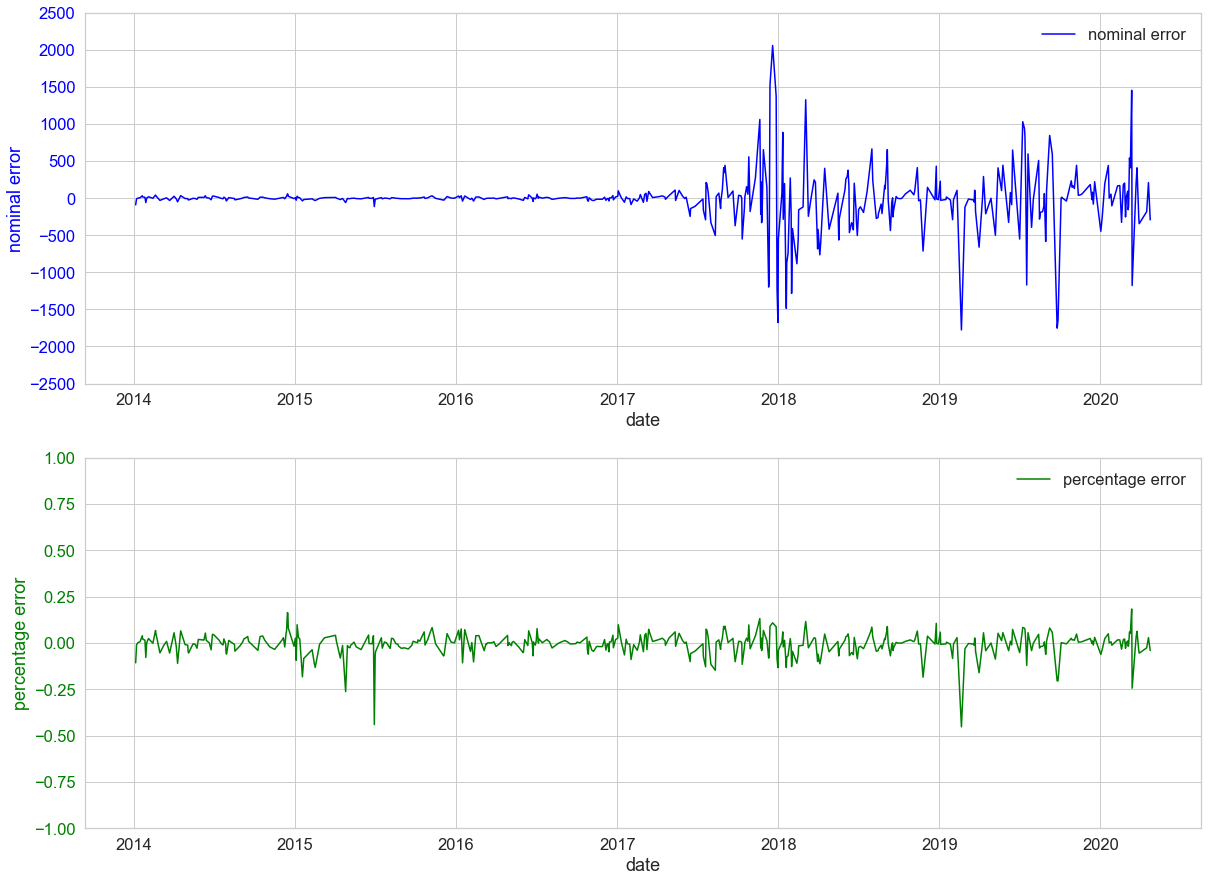

In [130]:
fig,ax=plt.subplots(nrows=2,figsize=(20,15))

ax[0].plot(prediction.index,(prediction['true price']-prediction['predicted price']),color='blue',label='nominal error')
ax[0].set_ylabel('nominal error',color='blue')
ax[0].set_yticks(np.arange(-2500,3000,500))
ax[0].tick_params(axis='y', colors='blue')
ax[0].set_xlabel('date')
ax[0].legend()

ax[1].plot(prediction.index,(prediction['true price']-prediction['predicted price'])/prediction['true price'],color='green',label='percentage error')
ax[1].set_ylabel('percentage error',color='green')
ax[1].tick_params(axis='y', colors='green')
ax[1].set_ylim(-1,1)

ax[1].set_xlabel('date')
ax[1].legend()
plt.show()

Once again it shoud be emphasized that nominal price differences are not reliable because the price of bitcoin has been changing significantly. More meaningful parameter is percentage error.

3. Residual plots (__for percentage error__)

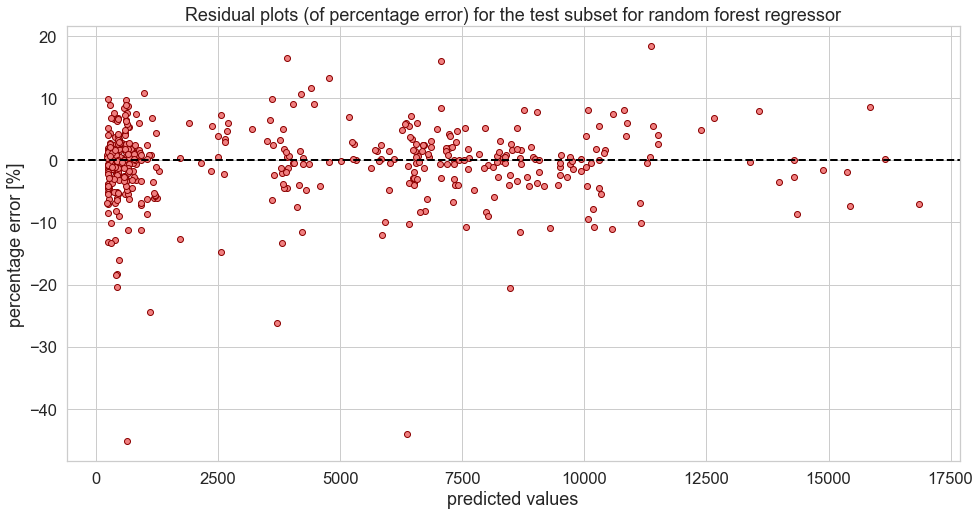

In [131]:
fig,ax=plt.subplots(figsize=(16,8))
residuals_test=y_test-y_pred
ax.scatter(y_pred,prediction['percentage error [%]'],color='LightCoral',ec='darkred')
ax.axhline(y=0,lw=2,ls='--',color='black')
ax.set(xlabel='predicted values',ylabel='percentage error [%]')
ax.set_title('Residual plots (of percentage error) for the test subset for random forest regressor')
plt.show()

Probability plot of residuals against the quantiles (__for percentage error__)

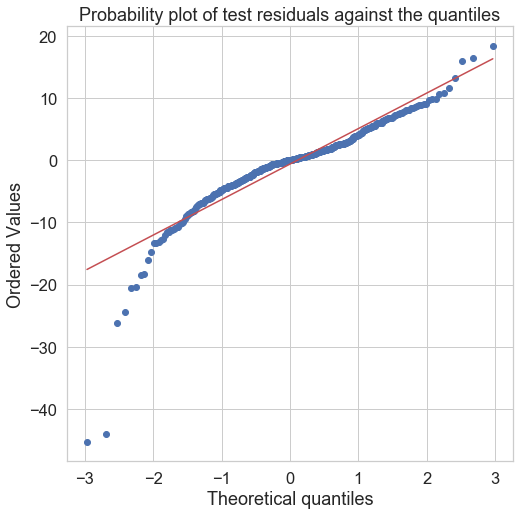

In [132]:
fig,ax = plt.subplots(figsize=(8,8))
# probplot(residuals_test, dist='norm', fit=True, plot=ax, rvalue=False)
probplot(prediction['percentage error [%]'], dist='norm', fit=True, plot=ax, rvalue=False)
ax.set_title('Probability plot of test residuals against the quantiles')
plt.show()

### Summary:

1. In this notebook three tree-based models were evaluated
    - regression tree
    - random forest regressor
    - gradient boosting regressor
    <br> At first the best parameters of each model were selected using GridSearchCV metod and then the best method was selected (calculating RMSE on the test set) for further investigation. It turned out that the best method is random forest regressor

2. Three-based method turned out to be much better than regression. RMSE for random forest is about 350 comparing to 1200 in regression.
3. Random forest performs quite well:
 - mean percentage error is about 4%
 - excluding few points residual plot has rather uniform distribution, no pattern is noticable
 - excluding few point probabilty plot is placed along the red line what makes the model correct
 - most of the percentage errors (over 80%) are less than 10%

### Conclusion

Built models showed that the tree-based methods are a great starting point for building bitcoin price prediction model. It must be emphasized that in practice the model built in this notebook is rather useless - to predict bitcoin price all used variables need to be known. While the values like M2 money supply or google trends don't change rapidly the other values change more dynamically. Not to mention that number of transaction are known at the end of a day. Last but not least, the price of bitcoin is very prone to geopolitical issues like banning the cryptocurrencies by goverments, new taxes etc. These are some kind of "black swans" - very hard to predict and even the best model would be incapable of taking it into account. 